# **Crash course in Probability**

---

### **Introduction**
This notebook gives a rapid introduction to the basics of probability theory. In particular, we highlight some uses of ideas from linear algebra: the variance-covariance matrix, the multivariate normal distribution, and conditional expectation as projection.

**NOTE:** The material in this notebook should be regarded as reference material to look back to when needed. 

---

### **Author**
**Junichi Koganemaru**  

---

### **References**
1. All of Statistics: A Concise Course in Statistical Inference by Larry Wasserman.
2. Chapter 2 of "An Introduction to Stochastic Differential Equations" by Lawrence C. Evans.
3. Chapter 2 of "Stochastic Calculus for Finance I" by Steven E. Shreve.


---

### **Recommended Reading and Resources**
1. [Random variable](https://en.wikipedia.org/wiki/Random_variable)
2. [Covariance and correlation](https://en.wikipedia.org/wiki/Covariance_and_correlation)
3. [Covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix)

---

### **Last Updated**
**January 22, 2025**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

## Introduction to Probability and Statistics

In practice, one often wants to model uncertainty with observed data. This is where probability and statistics come in. Roughly speaking, probability theory is the mathematical framework for modeling uncertainty, whereas statistics is the mathematical framework for making inference from data. 



## Probability spaces

### Bertrand's paradox

We start by discussing a variant of a classic problem in probability theory, Bertrand's paradox. Consider a circle of radius 2. We draw a chord "at random". What is the probability that the chord intersects a concentric circle of radius 1?

Possible solutions:

**Solution 1:** Any chord one draws is uniquely determined by its midpoint, provided it does not hit the center. Therefore the probabiltiy of the chord intersecting the inner circle is the same as the probability that the midpoint of the chord lies within the inner circle. The probability of this is the ratio of the area of the inner circle to the area of the outer circle, which is $\frac{1}{4}$.

**Solution 2:** By symmetry we may assume that the chord one draws is vertical. The diameter of the larger circle is 4, and the diameter of the smaller circle is 2. The chord will intersect the inner circle if its midpoint lies on the horizontal diameter of the inner circle, therefore the probability is $\frac{2}{4} = \frac{1}{2}$. 

**Solution 3:** By symmetry we assume that one end of the chord is fixed at the far left point of the larger circle. Any chord is uniquely determined by the angle $\theta \in (-\frac{\pi}{2}, \frac{\pi}{2})$ it makes with the horizontal axis. The chord will intersect the inner circle if the angle is between $-\frac{\pi}{6}$ and $\frac{\pi}{6}$. The probability is then $\frac{\frac{2\pi}{6}}{\frac{2\pi}{2}} = \frac{1}{3}$.


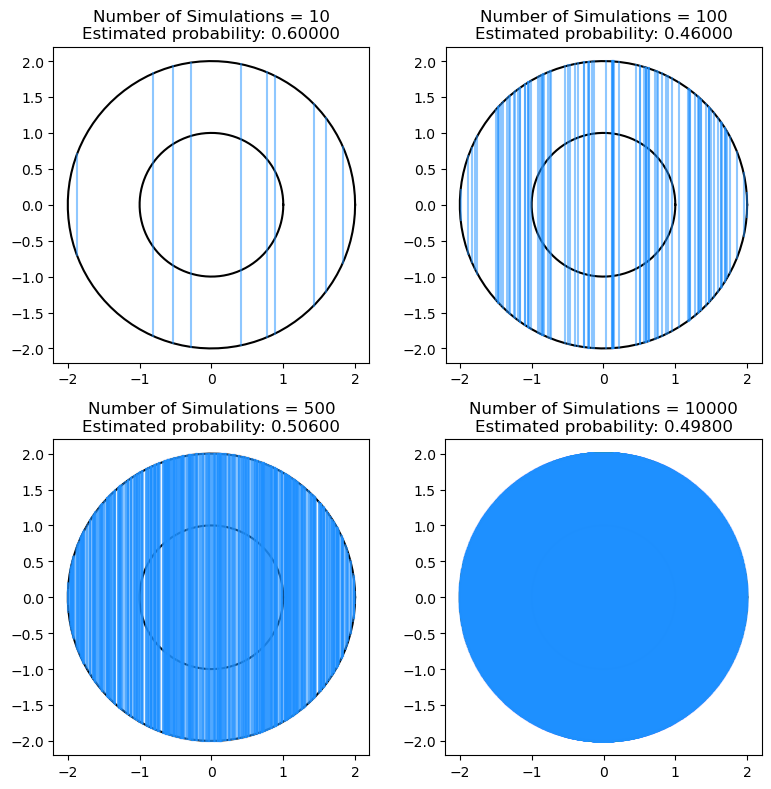

In [9]:
simulation_counts = [10, 100, 500, 10000]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

radius_inner, radius_outer = 1, 2

theta = np.linspace(0, 2 * np.pi, 100)
circle_inner_x, circle_inner_y  = radius_inner * np.cos(theta), radius_inner * np.sin(theta)
circle_outer_x, circle_outer_y = radius_outer * np.cos(theta),  radius_outer * np.sin(theta)

for ax, num_simulations in zip(axes.flatten(), simulation_counts):
    ax.plot(circle_inner_x, circle_inner_y, color='black')
    ax.plot(circle_outer_x, circle_outer_y, color='black')
    ax.set_aspect('equal')

    midpoints = np.random.uniform(-radius_outer, radius_outer, num_simulations)

    intersects = np.abs(midpoints) <= radius_inner
    probability = np.mean(intersects)

    for midpoint in midpoints:
        x1 = y1 = midpoint
        x2, y2 = np.sqrt(radius_outer**2 - midpoint**2) if radius_outer**2 - midpoint**2 >= 0 else 0, -np.sqrt(radius_outer**2 - midpoint**2) if radius_outer**2 - midpoint**2 >= 0 else 0
        ax.plot([x1, y1], [x2, y2], color='dodgerblue', alpha=0.5)

    ax.set_title(f'Number of Simulations = {num_simulations}\nEstimated probability: {probability:.5f}')
    
plt.tight_layout()
plt.show()

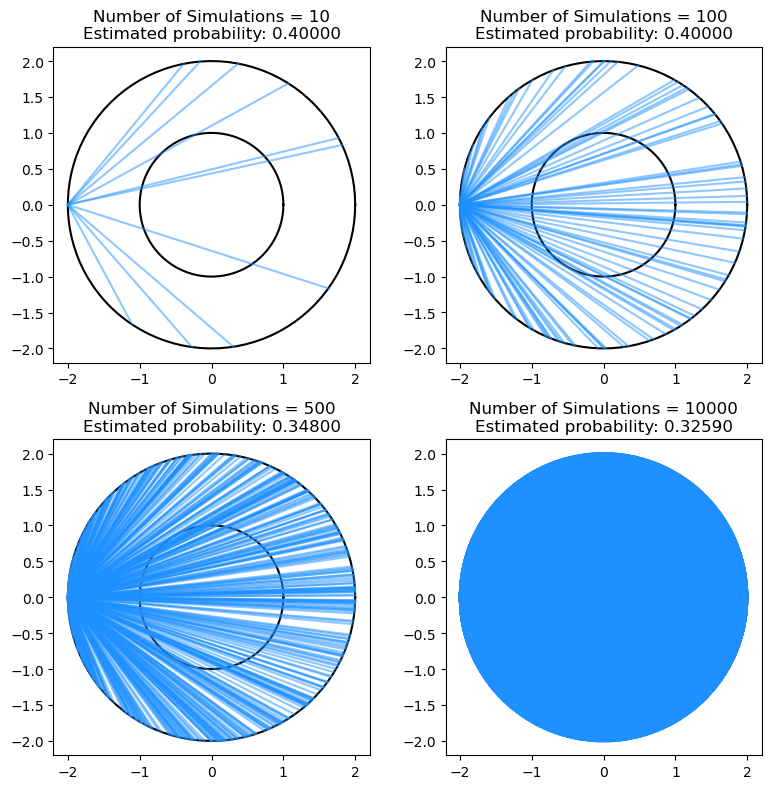

In [10]:
simulation_counts = [10, 100, 500, 10000]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for ax, num_simulations in zip(axes.flatten(), simulation_counts):
    ax.plot(circle_inner_x, circle_inner_y, color='black')
    ax.plot(circle_outer_x, circle_outer_y, color='black')
    ax.set_aspect('equal')

    angles = np.random.uniform(-np.pi/2, np.pi/ 2, num_simulations)
    
    intersects = np.abs(np.sin(angles)) <= radius_inner / radius_outer
    probability = np.mean(intersects)

    for angle in angles:
        x1, y1 = -radius_outer, 0
        x2, y2  = radius_outer * np.cos(2*angle), radius_outer * np.sin(2*angle)
        ax.plot([x1, x2], [y1, y2], color='dodgerblue', alpha=0.5)
        
    ax.set_title(f'Number of Simulations = {num_simulations}\nEstimated probability: {probability:.5f}')
    
plt.tight_layout()
plt.show()

### Probability spaces

None of these solutions are wrong per se, it is just that each of them have different assumptions about what it means to draw a chord "at random". This is because the phrase "at random" is not well-defined. In order to make sense of probability, we need to carefully define what it means for something to be "chosen at random." The mathematically rigorous way to do this is to introduce the notion of a **probability space**.

To introduce a probability space, one first starts with a nonempty set $\Omega$, called the **sample space**. The elements of $\Omega$ are called **outcomes** or **sample points**. Next we introduce a technical object called a **$\sigma$-algebra** defined on $\Omega$.

> **Definition ($\sigma$-algebra):**
A $\sigma$-algebra $\mathcal{F}$ is a collection of subsets of $\Omega$ that satisfies the following properties:
> 1. $\varnothing, \Omega \in \mathcal{F}$.
> 2. If $A \in \mathcal{F}$, then $A^c \in \mathcal{F}$. Here $A^c = \Omega \setminus A$ denotes the complement of $A$.
> 3. If $A_1, A_2, \ldots \in \mathcal{F}$, then $\bigcup_{i=1}^{\infty} A_i, \bigcap_{i=1}^\infty A_i \in \mathcal{F}$.

**Remark:** The elements of $\mathcal{F}$ are called **events** (sometime **measurable events**). 

> **Example:** Consider the sample space $\Omega = \{1,2,3\}$. The the **power set** of $\Omega$, denoted by $2^\Omega$ or sometimes $\mathcal{P}(\Omega)$, is the collection of all subsets of $\Omega$. For our example, $2^\Omega = \{ \varnothing, \{1\}, \{2\}, \{3\}, \{1, 2\}, \{2, 3\}, \{1, 3\}, \{1, 2, 3\}  \}$. One can check that the power set is a $\sigma$-algebra, and it is the largest possible $\sigma$-algebra on $\Omega$.

> **Example:** Consider the sample space $\Omega = \{1,2,3\}$. We can define $\mathcal{F} = \{ \varnothing, \{1,2,3\} \}$ as a $\sigma$-algebra on $\Omega$. This is the smallest possible $\sigma$-algebra on $\Omega$.

**Remark:** For finite sample spaces, the canonical choice of the $\sigma$-algebra is the power set. However, for infinite sets, the power set is often too large to work with.

Next we introduce the notion of a **probability measure**.

> **Definition (Probability measure):**
A probability measure $\mathbb{P}$ on a measurable space $(\Omega, \mathcal{F})$ is a function $\mathbb{P}: \mathcal{F} \to [0, 1]$ that satisfies the following properties:
> 1. $\mathbb{P}(\varnothing) = 0, \mathbb{P}(\Omega) = 1$.
> 2. If $A_1, A_2, \ldots \in \mathcal{F}$, then $$\mathbb{P}\left(\bigcup_{i=1}^\infty A_i \right) \leq \sum_{i=1}^\infty \mathbb{P}(A_i).$$
> 2. If $A_1, A_2, \ldots \in \mathcal{F}$ are pairwise disjoint, then $$\mathbb{P}\left(\bigcup_{i=1}^\infty A_i \right) = \sum_{i=1}^\infty \mathbb{P}(A_i).$$

Note that it follows that if $A \subseteq B$, then $\mathbb{P}(A) \leq \mathbb{P}(B)$ since $B = A \cup (B \setminus A)$ and $A$ and $B \setminus A$ are disjoint. $\mathbb{P}(A)$ is referred to as the **probability of the event $A$**.

Now we are ready to define a **probability space**.

> **Definition (Probability space):**
A probability space is a triple $(\Omega, \mathcal{F}, \mathbb{P})$, where $\Omega$ is the sample space, $\mathcal{F}$ is a $\sigma$-algebra of subsets of $\Omega$, and $\mathbb{P}$ is a probability measure on $(\Omega, \mathcal{F})$. 

**Important remark:** This is the most technical way of introducing the notion of a probability space. The $\sigma$-algebra is introduced for measure-theoretic reasons, and it is only necessary if $\Omega$ is uncountable. In practice, one typically assume that any "reasonable" event that one encounters is measurable, and so the $\sigma$-algebra is never explicitly mentioned and one simply defines a probability space as a pair $(\Omega, \mathbb{P})$. We follow this convention in the most of this notebook.

> **Example (Coin flip space)** Consider an experiment where we toss a coin once. We can model this by defining the sample space $\Omega_1 = \{H, T\}$, where $H$ denotes heads and $T$ denotes tails (this is just notation, $H,T$ can be replaced with other symbols). We can define a probability measure $\mathbb{P}$ by setting $\mathbb{P}(\{H\}) = \mathbb{P}(\{T\}) = \frac{1}{2}$ if one believes that the coin is unbiased, or in general define $\mathbb{P}(\{H\}) = p, \mathbb{P}(\{H\}) = q = 1-p$. This defines a probability space $(\Omega, \mathbb{P})$. 

> **Example (Coin flip space)** Consider an experiement where we toss a coin twice. We can model this by defining the sample space $\Omega_2 = \{HH,HT, TH, TT\}$ (one can think of $\Omega_2$ as being isomorphic to $\Omega_1 \times \Omega_1$), and defining a probability measure $\mathbb{P}: 2^\Omega \to [0,1]$ via $\mathbb{P}(\{HH\}) = p^2, \mathbb{P}(\{HT\}) = \mathbb{P}(\{TH\}) = pq, \mathbb{P}(\{TT\}) = q^2$, where $q = 1-p$. This defines a probability space $(\Omega, \mathbb{P})$. Events in $\Omega$ can often be described in words. For example, the event "the first toss is a head" is the set $\{HH, HT\}$, and the event "at least one toss is a head" is the set $\{HH, HT, TH\}$. If we want to compute the probability of these events, we can use the axioms associated with $\mathbb{P}$. For example, the probability of the event "the first toss is a head" is $$\mathbb{P}(\{HH, HT\}) = \mathbb{P}(\{HH\}) + \mathbb{P}(\{HT\}) = p^2 + pq = p^2 + p(1-p) = p.$$ The probability of the event "at least one toss is a head" can be computed via taking complements: $$\mathbb{P}(\{HH, HT, TH\}) = 1 - \mathbb{P}(\{TT\}) = 1 - q^2.$$

> **Example (Finite probability spaces)** Let $\Omega = \{\omega_1, \ldots , \omega_N\}$, where $N$ is a positive integer. Suppose $\{p_1, \ldots, p_N\}$ is a collection of nonnegative numbers that sum to 1. For any subset $A = \{\omega_{j1}, ..., \omega_{jm}\}$ of $\Omega$ with $1 \le j_1 < j_2 , \ldots, j_m \le N$, we define $\mathbb{P}(A) = p_{j1} + \ldots + p_{jk}$. This defines a probability space $(\Omega, \mathbb{P})$. If $p_1 = ... = p_N = \frac{1}{N}$, then this is called the **uniform probability measure** on $\Omega$. From this we see that $\mathbb{P}(A) = \frac{|A|}{N}$, where $|A|$ denotes the number of elements in $A$. This is also sometimes referred to as the **counting measure**.

> **Example (A probability measure on $\mathbb{R}^n$)** If $f: \mathbb{R}^n \to \mathbb{R}$ is a non-negative, integrable function such that $\int_{\mathbb{R}^n} f(x) dx = 1$, then we can define a probability measure $\mathbb{P}$ on subsets* of $\mathbb{R}^n$ by setting $$\mathbb{P}(A) = \int_A f(x) dx$$ for $A \subseteq \mathbb{R}^n$. This defines a probability space $(\mathbb{R}^n, \mathbb{P})$. An important example of this is when $f: \mathbb{R} \to \mathbb{R}$ is defined via $f(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}$.

*The $\sigma$-algebra we take here is usually the Borel $\sigma$-algebra, which is the smallest $\sigma$-algebra that contains all open sets in $\mathbb{R}^n$. Throughout this notebook, whenever $\Omega = \mathbb{R}^n$, we implicitly assume that the underlying $\sigma$-algebra $\mathcal{F}$ is the Borel $\sigma$-algebra. One can essentially think of $\mathcal{F}$ as the collection of "nice" subsets of $\mathbb{R}^n$.

**Remark:** The function $f$ is referred to as the **density** of the probability measure $\mathbb{P}$.  

## Random variables

Probability spaces can be thought of as essential mathematical objects can be used to model experiments, however they are themselves not "directly observable" as the state space $\Omega$ is an abstract construct. We therefore introduce functions from $\Omega$ to $\mathbb{R}^n$ that assign numerical values to outcomes in $\Omega$, for which we can then "observe" explicitly. These mappings are referred to as **random variables** in probability.

> **Definition (Random variable):**
A random variable $X$ on a probability space $(\Omega, \mathbb{P})$ is a (measurable) function $X: \Omega \to \mathbb{R}$. 

> **Definition (Random vector):**
A random vector $\boldsymbol{X} = (X_1, \ldots, X_n)$ on a probability space $(\Omega, \mathbb{P})$ is a (measurable) function $\boldsymbol{X}: \Omega \to \mathbb{R}^n$. One can think of a random vector in terms of its components:
$$ \boldsymbol{X} = \begin{pmatrix} X_1 \\ \vdots \\ X_n \end{pmatrix},$$
where $X_1, \ldots, X_n: \Omega \to \mathbb{R}$ are random variables.

**Remark:** Some textbooks do not make the distinction between random variables and random vectors, and simply refer to both as random variables. 

**Remark:** Technically, random variables must be *measurable* functions. These are functions $X: \Omega \to \mathbb{R}^n$ such that for any Borel set $\mathcal{B} \subseteq \mathbb{R}^n$, the set $X^{-1}(\mathcal{B}) = \{ \omega \in \Omega : X(\omega) \in \mathcal{B}\}$ is measurable in $\Omega$. Since we are ignoring the underlying $\sigma$-algebras in this notebook, we will also ignore this technical detail. 

> **Example (Random variables on coin toss spaces):** Consider the coin flip space $(\Omega, \mathbb{P})$ where $\Omega = \{HH,HT, TH, TT\}$ and $\mathbb{P}(\{HH\}) = \mathbb{P}(\{HT\}) = \mathbb{P}(\{TH\}) = \mathbb{P}(\{TT\}) = \frac{1}{4}$. We can define a random variable $X$ that counts the total number of heads in the two coin flips. Explicitly, we define the function $X: \Omega \to \mathbb{R}$ via $X(HH) = 2, X(HT) = X(TH) = 1, X(TT) = 0$. This defines a random variable $X$ on $(\Omega, \mathbb{P})$.

With the language of measure theory, we can unify the treatment of *discrete* and *continuous* random variables, however in practice it is better to think of them separately for computational reasons. We define these below.

> **Definition (Discrete and continuous random variable):**
A random variable $X: \Omega \to \mathbb{R}^n$ is said to be a *discrete random variable* if the range of $X$ is countable. A random variable $X \to \mathbb{R}^n$ is said to be *continuous random variable* if the range of $X$ is uncountable.

### Notation involving random variables

Probabilists have developed their own set of conventions with notation that one should be aware of. For example, if $(\Omega, \mathbb{P})$ is a probability space and $X: \Omega \to \mathbb{R}$ is a random variable,
* The set $\{ \omega \in \Omega : X(\omega) > a\}$ is usually written as $\{ X > a \}$
* $\mathbb{P}(\{ \omega \in \Omega : X(\omega) > a\})$ is usually written as $\mathbb{P}(X > a)$
* If $B \subseteq \mathbb{R}$ and $X^{-1}(B) = \{ \omega \in \Omega : X(\omega) \in B\}$, then $\mathbb{P}(X^{-1}(B))$ is usually written as $\mathbb{P}(X \in B)$
* The collection of random variables on $(\Omega, \mathbb{P})$ is usually denoted as $L^0(\Omega, \mathbb{P})$.


## Expectation and variance of random variables

Next we want to define the notion of the *expectation* of a random variable. The expectation of a random variable is a measure of the "average" value of the random variable. To do so we first need to understand how to integrate random variables with respect to probability measures.

### Integration of random variables with respect to probability measures

First we define the notation of an indicator or characteristic function.

> **Definition (Indicator function):**
Let $(\Omega, \mathbb{P})$ be a probability space and let $A \subseteq \Omega$ be an event. The indicator function of $A$ is the function $\boldsymbol{1}_A: \Omega \to \mathbb{R}$ defined by $$\boldsymbol{1}_A(\omega) = \begin{cases} 1, & \omega \in A \\ 0, & \omega \notin A \end{cases}$$

With indicator functions, we can define the notion of a *simple random variable*.

> **Definition (Simple random variable):**
Let $(\Omega, \mathbb{P})$ be a probability space . A simple random variable $X: \Omega \to \mathbb{R}$ is a random variable of the form $$X(\omega) = \sum_{i=1}^n a_i \boldsymbol{1}_{A_i}(\omega)$$ where $a_1, \ldots, a_n \in \mathbb{R}$ and $A_1, \ldots, A_n$ are events in $\Omega$.


Next we define the integral of a simple random variable with respect to a probability measure.

> **Definition (Integral of a simple random variable):**
Let $(\Omega, \mathbb{P})$ be a probability space and let $X: \Omega \to \mathbb{R}$ be a simple random variable of the form $X(\omega) = \sum_{i=1}^n a_i \boldsymbol{1}_{A_i}(\omega)$. The integral of $X$ with respect to $\mathbb{P}$ is defined by $$\int_\Omega X d\mathbb{P} = \sum_{i=1}^n a_i \mathbb{P}(A_i).$$

Now we follow the standard recipe from measure theory to define the integral of a general random variable with respect to a probability measure.

* If $X$ is a non-negative simple random variable, then we define 
$$
\int_\Omega X d\mathbb{P} = \sup_{Y \le X, Y \text{ simple}} \int_\Omega Y d\mathbb{P}.
$$
We note that it is possible for the supremum to be infinite.

* If $X$ is a general random variable, then we write $X = X^+ - X^-$, where $X^+ = \max(X, 0)$ and $X^- = \max(-X, 0)$. We define
$$
\int_\Omega X d\mathbb{P} = \int_\Omega X^+ d\mathbb{P} - \int_\Omega X^- d\mathbb{P}.
$$
provided that one of the integrals on the right-hand side is finite.

For random vectors, we define the integral component-wise. If $\boldsymbol{X} = (X_1, \ldots, X_n)$ is a random vector, then we define
$$
\displaystyle \int_\Omega \boldsymbol{X} d\mathbb{P} = \begin{pmatrix} \int_\Omega X_1 d\mathbb{P} \\ \vdots \\ \int_\Omega X_n d\mathbb{P} \end{pmatrix}.
$$

### Expectation and variance of random variables

With the notion of integration in place, we can now define the expectation of a random variable and random vectors. 

> **Definition (Expectation of random variables):**
Let $X: \Omega \to \mathbb{R}$ be a random variable and on a probability space $(\Omega, \mathbb{P})$. The expectation of $X$ is defined by $$\mathbb{E}[X] = \int_\Omega X d\mathbb{P}.$$

**Remark:** If $X$ is a discrete random variable, then the expectation of $X$ can be computed via the formula $$\mathbb{E}[X] = \sum_{x \in \text{range}(X)} x \mathbb{P}(X = x).$$

**Note:** This defintion can be extended to random vectors in a straightforward manner. If $\boldsymbol{X} = \begin{pmatrix} X_1 \\ \vdots \\ X_n \end{pmatrix}$ is a random vector, then we define the expectation of $\boldsymbol{X}$ by $$\mathbb{E}[\boldsymbol{X}] = \int_\Omega \boldsymbol{X} d\mathbb{P}  = \begin{pmatrix}\mathbb{E}[X_1] \\ \vdots \\ \mathbb{E}[X_n] \end{pmatrix}.$$

It also follows that 
$$
\mathbb{E}[a\boldsymbol{X} + b\boldsymbol{Y}] = a\mathbb{E}[\boldsymbol{X}] + b\mathbb{E}[\boldsymbol{Y}]
$$
if $a,b \in \mathbb{R}$ and $\boldsymbol{X},\boldsymbol{Y}$ are random vectors

Next we define the variance of a random variable.

> **Definition (Variance of random variables):**
Let $(\Omega, \mathbb{P})$ be a probability space and suppose $X$ is a random variable with finite expectation. The variance of $X$ is defined via $$\text{Var}[X] = \mathbb{E}[(X - \mathbb{E}[X])^2].$$

For random vectors with finite expectation, the variance is defined via 
$$
\text{Var}[\boldsymbol{X}] = \int_\Omega |\boldsymbol{X}  - \mathbb{E}[\boldsymbol{X} ]|^2  = \mathbb{E}[|\boldsymbol{X} |^2] - |\mathbb{E}[\boldsymbol{X} ]|^2.
$$

**Note:** The expectation of a random vector is defined as a vector, whereas its variance is defined as a number. Some authors define the *variance matrix* of $\boldsymbol{X}$ via $\mathbb{E}[(\boldsymbol{X} - \mathbb{E}[\boldsymbol{X}])(\boldsymbol{X} - \mathbb{E}[\boldsymbol{X}])^T] \in \mathcal{M}_{n \times n}(\mathbb{R})$. We refer to this as the variance-covariance matrix to avoid confusion with the scalar variance.

The *standard deviation* of a random variable is defined as the square root of its variance. We also note that if $a,b \in \mathbb{R}$, then $\text{Var}[aX + b] = a^2 \text{Var}[X]$.



### Vector space structure of random variables 

**Important remark:** Not only is the collection of random variables $L^0(\Omega, \mathbb{P})$ a set, it carries a natural vector space structure! We simply define the sum and scalar product of random variables pointwise:

* If $X, Y \in L^0(\Omega, \mathbb{P})$, then $X + Y:\Omega \to \mathbb{R}$ is the random variable defined via $(X + Y)(\omega) = X(\omega) + Y(\omega)$.
* If $X \in L^0(\Omega, \mathbb{P})$ and $a \in \mathbb{R}$, then $aX:\Omega \to \mathbb{R}$ is the random variable defined via $(aX)(\omega) = aX(\omega)$.

However, $L^0(\Omega, \mathbb{P})$ is an infinite-dimensional vector space, so not all results from finite-dimensional vector spaces apply. For example, the notion of a basis needs to be carefully defined in this context.

Furthermore, in practice we often only work with random variables with finite expectation and variance. In general, one defines the $p$-th moment of a random variable $X$ by $\mathbb{E}[|X|^p]$. Since $|\mathbb{E}[X]| \leq \mathbb{E}[|X|]$, the expectation and the variance of a random variable is finite if it belongs to the vector space $L^1(\Omega, \mathbb{P}) \cap L^2(\Omega, \mathbb{P})$. This is usually the collection of random variables considered in practice.

As we will see later, this vector space also carries a natural inner product structure, which allows us to define notions of orthogonality and projections of random variables. 

## Distribution functions

Let $(\Omega, \mathbb{P})$ be a probability space and let $X: \Omega \to \mathbb{R}^n$ be a random vector. For $\boldsymbol{x}, \boldsymbol{y} \in \mathbb{R}^n$, we use the notation $x \le y$ to mean that $(\boldsymbol{x})_i \le (\boldsymbol{y})_i$ for all $i = 1, \ldots, n$.

> **Definition (Cummulative distribution function):**
The *cummulative distribution function* of a random vector $\boldsymbol{X}$ is the function $F_{\boldsymbol{X}}: \mathbb{R}^n \to [0,1]$ defined by $$F_{\boldsymbol{X}}(\boldsymbol{x}) = \mathbb{P}(\boldsymbol{X} \le \boldsymbol{x}).$$

> **Definition (Joint cummulative distribution function):**
The *joint cummulative distribution function* of a collection of random vectors $\boldsymbol{X}_1, ..., \boldsymbol{X}_n: \Omega \to \mathbb{R}^n$ is the function $F_{\boldsymbol{X}_1, ..., \boldsymbol{X}_n}: \mathbb{R}^{n} \times ... \times \mathbb{R}^{n} \to [0,1]$ defined by $$F_{\boldsymbol{X}_1, ..., \boldsymbol{X}_n}(\boldsymbol{x}_1, ..., \boldsymbol{x}_n) = \mathbb{P}(\boldsymbol{X}_1 \le \boldsymbol{x}_1, ..., \boldsymbol{X}_n \le \boldsymbol{x}_n).$$ 


> **Definition (Probability density function):**
Let $\boldsymbol{X}: \Omega \to \mathbb{R}^n$ be a random vector and $F_{\boldsymbol{X}}$ is its distribution function. If there exists a function $f_{\boldsymbol{X}}: \mathbb{R}^n \to \mathbb{R}$ such that for all $\boldsymbol{x} \in \mathbb{R}^n$, $$F_{\boldsymbol{X}}(\boldsymbol{x}) = F(x_1, ..., x_n) = \int_{-\infty}^{x_1} ... \int_{-\infty}^{x_n} f(y_1, ..., y_n) d y_n ... dy_1,$$ then $f$ is called the *probability density function* of the random vector $\boldsymbol{X}$.

It follows from the definition that if $f_{\boldsymbol{X}}$ is the probability density function of $\boldsymbol{X}$, then for any Borel set $\mathcal{B} \subseteq \mathbb{R}^n$, $$\mathbb{P}(\boldsymbol{X} \in \mathcal{B} ) = \int_{\mathcal{B}}  f_{\boldsymbol{X}}(\boldsymbol{x}) d\boldsymbol{x}.$$

**Important remark:** This observation is important as it shows that as long as the density function $f_{\boldsymbol{X}}$ exists, all quantities of interest related to a random vector can be computed as integrals over $\mathbb{R}^n$.

> **Example (Gaussian random variable)** If $X: \Omega \to \mathbb{R}$ has the probability density function $f_X: \mathbb{R} \to \mathbb{R}$ given by  
> $$  
> f_X(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -\frac{(x-\mu)^2}{2 \sigma^2} \right),  
> $$  
> then we say that $X$ is a Gaussian (or normal) random variable with mean $\mu$ and variance $\sigma^2$. In this case we write $X \sim N(\mu, \sigma^2)$. If $X \sim N(0,1)$, then we say that $X$ is a standard Gaussian random variable.

One can show via computation that if $X \sim N(\mu, \sigma^2)$, then $\mathbb{E}[X] = \mu$ and $\text{Var}[X] = \sigma^2$. One can also derive the following useful facts:
* If $X \sim N(\mu, \sigma^2)$, then $aX + b \sim N(a\mu + b, a^2\sigma^2)$. In particular, $Z = \frac{X - \mu}{\sigma} \sim N(0,1)$.
* If $Z \sim N(0,1)$, then $X = \mu + \sigma Z \sim N(\mu, \sigma^2)$.


> **Example (Gaussian random vector)** If $X: \Omega \to \mathbb{R}^n$ has the probability density function $f_{\boldsymbol{X}}: \mathbb{R}^n \to \mathbb{R}$ given by  
> $$  
> f_{\boldsymbol{X}}(\boldsymbol{x}) = \frac{1}{\sqrt{ (2\pi)^n \det \Sigma}} \exp\left(-\frac{1}{2} (\boldsymbol{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{x} - \boldsymbol{\mu}) \right),
> $$  
> where $\boldsymbol{\mu} \in \mathbb{R}^n$  and $\Sigma \in \mathcal{M}_{n \times n}$ is a (symmetric) positive definite matrix, then we say that $\boldsymbol{X}$ is a Gaussian (or normal) random vector with mean $\boldsymbol{\mu}$ and covariance matrix $\Sigma$. In this case we write $\boldsymbol{X} \sim N(\boldsymbol{\mu}, \Sigma)$. If $\boldsymbol{X} \sim N(\boldsymbol{0}, I)$, then we say that $\boldsymbol{X}$ is a standard Gaussian random vector. 

We note that if $\boldsymbol{X} \sim N(\boldsymbol{\mu}, \sigma^2 I)$, then the density function reduces to 
> $$  
> f_{\boldsymbol{X}}(\boldsymbol{x}) = \frac{1}{\sqrt{ (2\pi \sigma^2 )^n }}  \exp\left( -\frac{\sum_{i=1}^n (x_i - \mu_i)^2}{2 \sigma^2} \right),  
> $$ 

**Note:** The factor $\sqrt{ (2\pi)^n \det \Sigma}$ in the density function is chosen so that the integral of the density function over $\mathbb{R}^n$ is equal to 1. We will perform this calculation later when we discuss calculus with matrices.

To get some intuition for the Gaussian distribution, we plot the density functions a few Gaussian random variables below.

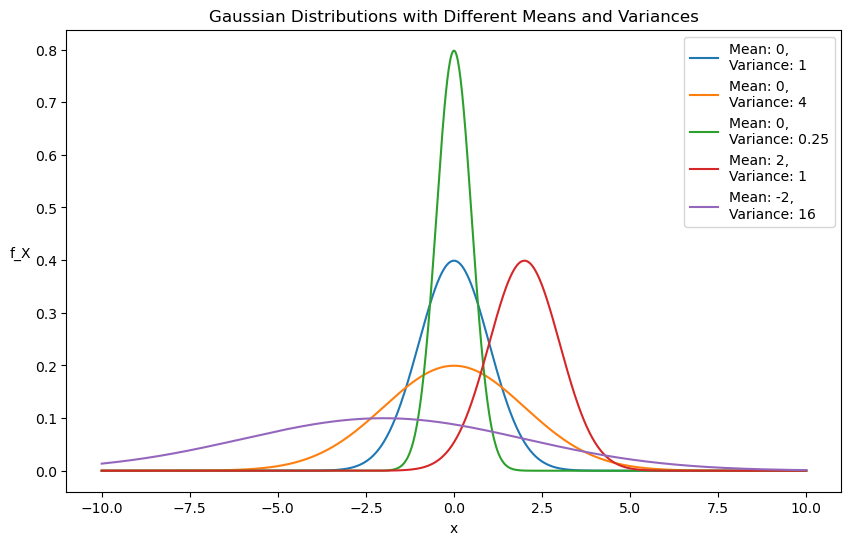

In [10]:
import numpy as np
import matplotlib.pyplot as plt

means = [0, 0, 0, 2, -2]
std_devs = [1, 2, 0.5, 1, 4]

x = np.linspace(-10, 10, 1000)

fig, ax = plt.subplots(figsize=(10, 6))

for mean, std_dev in zip(means, std_devs):
    y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    ax.plot(x, y, label=f'Mean: {mean},\nVariance: {std_dev**2}')

ax.set_title('Gaussian Distributions with Different Means and Variances')
ax.set_xlabel('x')
ax.set_ylabel('f_X', rotation=0, labelpad=10)
ax.legend()

plt.show()

In [ ]:
means = [[0, 0], [1, 1], [-1, -1]]
covariances = [np.array(x) for x in [[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]], [[2, 0.3], [0.3, 0.5]]]]

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

fig = plt.figure(figsize=(18, 18))
num_samples = 500

for i, (mean, cov) in enumerate(zip(means, covariances)):
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    
    ax = fig.add_subplot(len(means), 2, 2*i + 1, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax.set_title(f'Bivariate Normal Distribution \nMean: {mean}, Covariance matrix: \n{cov}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Density')

    ax = fig.add_subplot(len(means), 2, 2*i + 2)
    samples = np.random.multivariate_normal(mean, cov, num_samples)
    ax.scatter(samples[:, 0], samples[:, 1], marker='x')
    ax.set_title(f'Sample Points\nMean: {mean}, Covariance matrix: \n{cov}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_aspect('equal')

    marginal_x_density = multivariate_normal(mean[0], cov[0][0]).pdf(x)
    marginal_y_density = multivariate_normal(mean[1], cov[1][1]).pdf(y)
    
    ax.plot(x, marginal_x_density, color='red', label='Marginal X Density')
    ax.plot(marginal_y_density, y, color='blue', label='Marginal Y Density')
    ax.legend()

plt.tight_layout()
plt.show()




**Proposition (The law of the unconscious statistician):** Let $\boldsymbol{X}: \Omega \to \mathbb{R}^n$ be a random variable, and assume that its distribution function $F_{\boldsymbol{X}}$ has the density $f_{\boldsymbol{X}}$. Suppose $g: \mathbb{R}^n \to \mathbb{R}$ is a (measureable) function and $g(\boldsymbol{X}) \in \mathcal{L}^1(\Omega, \mathbb{P})$. Then 
$$\mathbb{E}[g(\boldsymbol{X})] = \int_{\mathbb{R}^n} g(\boldsymbol{x}) f_{\boldsymbol{X}}(\boldsymbol{x}) d\boldsymbol{x}.$$



**Important remark:** This proposition allows us to complete the expectation and the variance of random variables and random vectors explicitly in terms of integrals over $\mathbb{R}^n$. As mentioned previously, the probability space $(\Omega, \mathbb{P})$ is not "directly observable", all we can "observe" are the numerical outputs of random variables. This shows that as long the probability density function $f$ exists, all quantities of interest related to a random variable can be computed as an integral over $\mathbb{R}^n$. 

> **Example (Expectation of a Gaussian random variable)** Let $X \sim N(\mu, \sigma^2)$ be a Gaussian random variable. We can compute the expectation of $X$ by using the density function of $X$. Using a change of variables, we have 
> $$
> \mathbb{E}[X] = \int_{-\infty}^\infty x f_X(x) dx = \int_{-\infty}^\infty x \frac{1}{\sqrt{2\pi \sigma^2}} e^{-(x-\mu)^2/2} dx = \int_{-\infty}^\infty (\sigma u + \mu) \frac{1}{\sqrt{2\pi}} e^{-u^2/2} du = \mu \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi }} e^{-u^2/2} du = \mu.
> $$
> The variance of $X$ can be computed in a similar manner:
> $$
> \text{Var}[X] = \mathbb{E}[X^2] - \mathbb{E}[X]^2 = \int_{-\infty}^\infty x^2 f_X(x) dx - \mu^2 = \int_{-\infty}^\infty (\sigma^2 u^2 + 2\mu \sigma u + \mu^2) \frac{1}{\sqrt{2\pi}} e^{-u^2/2} du - \mu^2 = \sigma^2 \int_{-\infty}^\infty u^2  \frac{1}{\sqrt{2\pi }} e^{-u^2/2} du = \sigma^2.
> $$

We conclude this section by defining the marginal density function of a random vector.

> **Definition (Marginal density function):**
Let $\boldsymbol{X} = (X_1, \ldots, X_n)$ be a random vector with density function $f_{\boldsymbol{X}}: \mathbb{R}^n \to \mathbb{R}$. The marginal density function of $X_i$ is the function $f_{X_i}: \mathbb{R} \to \mathbb{R}$ defined by $$f_{X_i}(x) = \int_{\mathbb{R}^{n-1}} f_{\boldsymbol{X}}(x_1, ..., x_{i-1}, x, x_{i+1}, ..., x_n) dx_1 ... dx_{i-1} dx_{i+1} ... dx_n.$$

# Discrete random variables

Here we record some of the formulas above when the underlying random variable is discrete.

* Expectation: $$\mathbb{E}[X] = \sum_{x \in \text{range}(X)} x \mathbb{P}(X = x).$$ The function $p: \text{range}(X) \to [0,1]$ defined by $p(x) = \mathbb{P}(X = x)$ is called the **probability mass function** of $X$.
* Variance: if $\mathbb{E}[X]$ is finite, then 
$$\text{Var}[X] = \mathbb{E}[(X - \mathbb{E}[X])^2] = \sum_{x \in \text{range}(X)} (x - \mathbb{E}[X])^2 \mathbb{P}(X = x).$$
* Law of unconscious statistician: If $g$ is measurable and $g(X)$ is integrable, then 
$$
\mathbb{E}[g(X)] = \sum_{x \in \text{range}(X)} g(x) \mathbb{P}(X = x).
$$

All of these formulas can be extended to random vectors in a fairly straightforward manner.

## Common probability distributions

In practice, one typically says that a random variable $X$ is drawn from or follows a certain probability distribution. What this means is that the random variable $X$ can be described by a certain probability mass, density, or cummulative distribution function. Here we list some of the most common probability distributions that one encounters in practice.

### Discrete random variables

* **Bernoulli distribution**: A random variable $X: \Omega \to \{0,1\}$ follows a Bernoulli distribution with parameter $p$ if it takes the value 1 with probability $p$ and the value 0 with probability $1-p$. The probability mass function is given by:
    $$
    \mathbb{P}(X = x) = \begin{cases} 
    p & \text{if } x = 1 \\
    1-p & \text{if } x = 0 
    \end{cases}
    $$

* **Binomial distribution**: A random variable $X: \Omega \to \{0,1, ..., n\}$ follows a Binomial distribution with parameters $n$ and $p$ if it represents the number of successes in $n$ independent Bernoulli trials with success probability $p$. Its probability mass function is given by:
    $$
    \mathbb{P}(X = k) = \binom{n}{k} p^k (1-p)^{n-k} \quad \text{for } k = 0, 1, \ldots, n
    $$

* **Geometric distribution**: A random variable $X: \Omega \to \{1,2,...\}$ follows a Geometric distribution with parameter $p$ if it represents the number of trials needed to get the first success in a sequence of independent Bernoulli trials with success probability $p$. Its probability mass function is given by:
    $$
    \mathbb{P}(X = k) = (1-p)^{k-1} p \quad \text{for } k = 1, 2, \ldots
    $$

*  **Poisson distribution**: A random variable $X: \Omega \to \{1,2,...\}$ follows a Poisson distribution with parameter $\lambda > 0$ if it represents the number of events occurring in a fixed interval of time or space, with the events occurring independently at a constant average rate $\lambda$. Its probability mass function is given by:
    $$
    \mathbb{P}(X = k) = \frac{\lambda^k e^{-\lambda}}{k!} \quad \text{for } k = 0, 1, 2, \ldots
    $$
    
* **Multinomial distribution**: A random vector $\boldsymbol{X} = (X_1, X_2, \ldots, X_k): \Omega \to \{0, 1, \ldots, n\}^k$ follows a Multinomial distribution with parameters $n$ and $\boldsymbol{p} = (p_1, p_2, \ldots, p_k)$ if it represents the counts of $k$ different outcomes in $n$ independent trials, where each trial results in exactly one of the $k$ outcomes with probabilities $p_1, p_2, \ldots, p_k$. Its probability mass function is given by:
        $$
        \mathbb{P}(X_1 = x_1, X_2 = x_2, \ldots, X_k = x_k) = \frac{n!}{x_1! x_2! \cdots x_k!} p_1^{x_1} p_2^{x_2} \cdots p_k^{x_k} \quad \text{for } x_1 + x_2 + \cdots + x_k = n
        $$

### Continuous random variables

*  **Uniform distribution**: A random variable $X: \Omega \to \mathbb{R}$ follows a Uniform distribution on the interval $[a, b]$ if it has an equal probability of taking any value in that interval. The probability density function is given by:
    $$
    f_X(x) = \begin{cases} 
    \frac{1}{b-a} & \text{if } a \le x \le b \\
    0 & \text{otherwise}
    \end{cases}
    $$

*  **Gaussian distribution**: A random variable $X: \Omega \to \mathbb{R}$ follows a Gaussian or Normal distribution with mean $\mu$ and variance $\sigma^2$ if its probability density function is given by:
    $$
    f_X(x) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
    $$

*  **Exponential distribution**: A random variable $X: \Omega \to \mathbb{R}$ follows an Exponential distribution with parameter $\lambda > 0$ if it represents the time between events in a Poisson process with rate $\lambda$. The probability density function is given by:
    $$
    f_X(x) = \begin{cases} 
    \lambda e^{-\lambda x} & \text{if } x \ge 0 \\
    0 & \text{otherwise}
    \end{cases}
    $$

*  **Gamma distribution**: A random variable  $X: \Omega \to \mathbb{R}$ follows a Gamma distribution with shape parameter $\alpha > 0$ and rate parameter $\beta > 0$ if its probability density function is given by:
    $$
    f_X(x) = \frac{\beta^\alpha x^{\alpha-1} e^{-\beta x}}{\Gamma(\alpha)} \quad \text{for } x \ge 0
    $$
    where $\Gamma: (0,\infty) \to \mathbb{R}$ is the Gamma function.


* **Multivariate normal distribution**: A random vector $\boldsymbol{X} = (X_1, X_2, \ldots, X_n): \Omega \to \mathbb{R}^n$ follows a Multivariate Normal distribution with a vector $\boldsymbol{\mu} \in \mathbb{R}^n$ and and a positive definite matrix $\Sigma \in \mathcal{M}_{n \times n}(\mathbb{R})$ if its probability density function is given by:
        $$
        f_{\boldsymbol{X}}(\boldsymbol{x}) = \frac{1}{\sqrt{(2\pi)^n \det \Sigma}} \exp\left(-\frac{1}{2} (\boldsymbol{x} - \boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{x} - \boldsymbol{\mu})\right)
        $$
        where $\boldsymbol{x} \in \mathbb{R}^n$.


## Covariance and correlation

Next we define the notion of the covariance and correlation of random vectors. Heuristically, the covariance of two random variables measures how close two random variables are linearly related to each other, as well as quantifying how this relation changes under scaling. 

> **Definition (Covariance of random variables):**
Let $X,Y: \Omega \to \mathbb{R}$ be random variables with finite expectation. The covariance of $X$ and $Y$ is defined by $$\text{Cov}[X,Y] = \mathbb{E}[(X - \mathbb{E}[X])(Y - \mathbb{E}[Y])] = \mathbb{E}[XY] - \mathbb{E}[X]\mathbb{E}[Y].$$
The correlation of $X$ and $Y$ is defined by $$\text{Corr}[X,Y] = \frac{\text{Cov}[X,Y]}{\sqrt{\text{Var}[X]\text{Var}[Y]}}.$$

**Remark:** We note that $-1 \le \text{Corr}[X,Y] \le 1$. If $\text{Cov}[X,Y] = 0$ or $\text{Corr}[X,Y] = 0$, then $X$ and $Y$ are said to be **uncorrelated**. 

Note that if $Y = aX + b$ for some $a,b \in \mathbb{R}$, then $\text{Cov}[X,Y] = a\text{Var}[X]$ and $\text{Corr}[X,Y] = \text{sgn}(a)$. For example, if $Y = aX + b$ and $a > 0$, then $\text{Corr}[X,Y] = 1$. If $a < 0$, then $\text{Corr}[X,Y] = -1$.

We also note that $\text{Cov}[X,X] = \text{Var}[X]$ and $\text{Corr}[X,X] = 1$.

If $X,Y$ have mean zero, then $\text{Cov}[X,Y] = \mathbb{E}[XY] = \int_\Omega X Y d \mathbb{P}$. This should be thought of as the analogue of the inner product of two vectors in $\mathbb{R}^n$.

## The variance-covariance matrix of a random vector

Given a random vector $\boldsymbol{X} = (X_1, X_2, \ldots, X_n)$, we can define the variance-covariance matrix of $\boldsymbol{X}$ as the matrix $\Sigma_{\boldsymbol{X}}  \in \mathcal{M}_{n \times n}(\mathbb{R})$ defined via  
$$
\Sigma_{\boldsymbol{X}} = \begin{pmatrix} \text{Var}[X_1] & \text{Cov}[X_1, X_2] & \cdots & \text{Cov}[X_1, X_n] \\ \text{Cov}[X_2, X_1] & \text{Var}[X_2] & \cdots & \text{Cov}[X_2, X_n] \\ \vdots & \vdots & \ddots & \vdots \\ \text{Cov}[X_n, X_1] & \text{Cov}[X_n, X_2] & \cdots & \text{Var}[X_n] \end{pmatrix}.$$

**Terminology:** Different authors use different terminology for the variance-covariance matrix. Some call it the covariance matrix, others call it the variance of the random vector $\boldsymbol{X}$. We will use the former terminology. 


The following proposition records some important properties of this matrix.

> **Proposition:** 
> Let $\boldsymbol{X} = (X_1, X_2, \ldots, X_n): \Omega \to \mathbb{R}^n$ be a random vector with mean $\boldsymbol{\mu} = (\mu_1, \mu_2, \ldots, \mu_n)$ and covariance matrix $\Sigma_{\boldsymbol{X}}$. Let
> $A \in \mathcal{M}_{m \times n}(\mathbb{R})$ and $\boldsymbol{b} \in \mathbb{R}^m$. The following hold.
> 1. $\Sigma_{\boldsymbol{X}} = \mathbb{E}[(\boldsymbol{X} - \mathbb{E}[\boldsymbol{X}])(\boldsymbol{X} - \mathbb{E}[\boldsymbol{X}])^T]$.
> 2. If $\boldsymbol{c} \in \mathbb{R}^n$, then $\mathbb{E}[\boldsymbol{c}^T \boldsymbol{X}] = \boldsymbol{c}^T \boldsymbol{\mu}$ and $\text{Var}[\boldsymbol{c}^T \boldsymbol{X}] = \boldsymbol{c}^T \boldsymbol{X} \boldsymbol{c}$.
> 3. If $\boldsymbol{Y} = A\boldsymbol{X} + \boldsymbol{b}$, then $\boldsymbol{Y}$ has mean $A\boldsymbol{\mu} + \boldsymbol{b}$ and covariance matrix $A\Sigma_{\boldsymbol{X}}A^T$.
> 4. $\Sigma_{\boldsymbol{X}}$ is positive semi-definite.

**Justfication:** Homework problem.

The next proposition relates the notion of the variance-covariance matrix to multivariate normal random variables.

> **Proposition:** Suppose $X \sim N(\boldsymbol{\mu}, \Sigma_{\boldsymbol{X}})$ is a multivariate normal random vector. Then the variance-covariance matrix of $X$ is $\Sigma_{\boldsymbol{X}}$.

**Justfication:** Homework problem.

To get some intuition for the variance-covariance matrix, let's run some numerical experiments and visualize the results when $n=2$. 

A normalized version of the variance-covariance matrix is the correlation matrix, which the matrix $\text{Corr}(\boldsymbol{X}) \in \mathcal{M}_{n \times n}(\mathbb{R})$ defined via
$$
\text{Corr}(\boldsymbol{X})= \begin{pmatrix} 1 & \text{Corr}[X_1, X_2] & \cdots & \text{Corr}[X_1, X_n] \\ \text{Corr}[X_2, X_1] & 1 & \cdots & \text{Corr}[X_2, X_n] \\ \vdots & \vdots & \ddots & \vdots \\ \text{Corr}[X_n, X_1] & \text{Corr}[X_n, X_2] & \cdots & 1 \end{pmatrix}.
$$

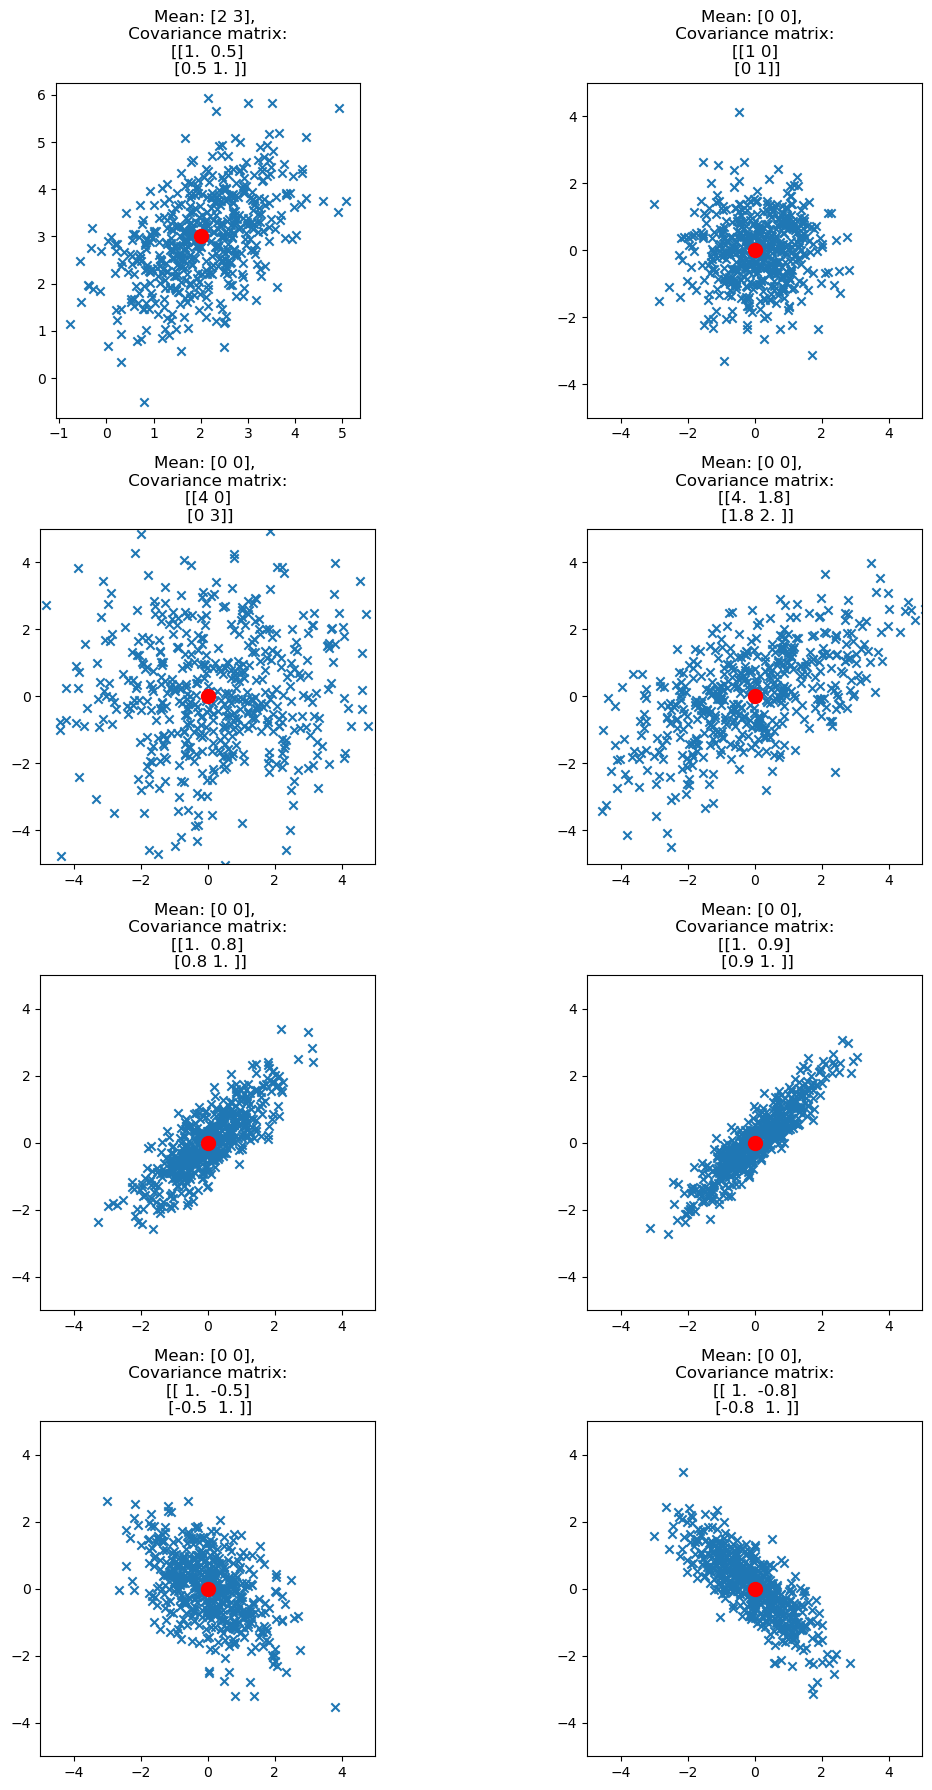

In [19]:
import numpy as np
import matplotlib.pyplot as plt

means = [np.array([2, 3]), np.array([0, 0]), np.array([0, 0]), np.array([0, 0]), np.array([0, 0]), np.array([0, 0]), np.array([0, 0]), np.array([0, 0])]
covariances = [
    np.array([[1, 0.5], [0.5, 1]]), 
    np.array([[1, 0], [0, 1]]), 
    np.array([[4, 0], [0, 3]]), 
    np.array([[4, 1.8], [1.8, 2]]), 
    np.array([[1, 0.8], [0.8, 1]]), 
    np.array([[1, 0.9], [0.9, 1]]),
    np.array([[1, -0.5], [-0.5, 1]]),
    np.array([[1, -0.8], [-0.8, 1]])
]

num_samples = 500

fig, axes = plt.subplots(4, 2, figsize=(12, 18))

for ax, mean, cov in zip(axes.flatten(), means, covariances):
    samples = np.random.multivariate_normal(mean, cov, num_samples)
    ax.scatter(samples[:, 0], samples[:, 1], marker='x')
    ax.scatter(mean[0], mean[1], color='red', marker='o', s=100, label=f'Center ({mean[0]}, {mean[1]})')
    ax.set_title(f'Mean: {mean}, \n Covariance matrix: \n{cov}')
    ax.set_aspect('equal')
    if not np.any(mean): 
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)

plt.tight_layout()
plt.show()

## Conditional probability and independence

Conditional probability is a way of measuring the probability of an event given that another event has occurred. To motivate the definition of conditional probability, let $A,B$ be two events with $\mathbb{P}(B) > 0$. Suppose some outcome $\omega \in \Omega$ is selected and we are given the information that $\omega \in B$. What is the probability that $\omega \in A$? 

Since we are already given that $\omega \in B$, we can regard $B$ is the "new" sample space. In order to do so the original probability measure $\mathbb{P}$ must be rescaled so that $\mathbb{P}(B) = 1$. To do so we can define a new probability measure $\mathbb{P}_B: \mathcal{F} \rvert_{B} \to [0,1]$ by normalizing by a factor of $\mathbb{P}(B)$: $\mathbb{P}_B(C) = \frac{\mathbb{P}(C)}{\mathbb{P}(B)}$ for all events $C \subseteq B$. Therefore the probability that $\omega$ lies in $A$ is $\mathbb{P}_B (A \cap B) = \frac{\mathbb{P}(A \cap B)}{\mathbb{P}(B)}$. This motivates the definition of conditional probability.

> **Definition (Conditional probability):**
Let $(\Omega, \mathbb{P})$ be a probability space and let $A,B$ be events with $\mathbb{P}(B) > 0$. The conditional probability of $A$ given $B$ is defined by $$\mathbb{P}(A|B) = \frac{\mathbb{P}(A \cap B)}{\mathbb{P}(B)}.$$ 


## Independence of events

Two events $A,B$ are said to be independent if $\mathbb{P}(A \mid B) = \mathbb{P}(A)$. This is saying that any information about $B$ is irrelevant in determining the probability that the event $A$ occured. We note that using the definition of condition probability, $ \mathbb{P}(A) =  \mathbb{P}(A \mid B) \implies \mathbb{P}(A \cap B) = \mathbb{P}(A) \mathbb{P}(B)$, and the latter is well-defined even if $\mathbb{P}(B) = 0$. Therefore we use this as the definition of independence.

> **Definition (Independence of events):**
Two events $A,B$ are said to be independent if $\mathbb{P}(A \cap B) = \mathbb{P}(A) \mathbb{P}(B)$.

This definition can be extended to a countable collection of events: events $A_1, A_2, \ldots$ are said to be independent if for all finite subsets $A_{i_1}, A_{i_2}, \ldots, A_{i_n}$, we have $\mathbb{P}(A_{i_1} \cap A_{i_2} \cap \ldots \cap A_{i_n}) = \mathbb{P}(A_{i_1}) \mathbb{P}(A_{i_2}) \cdots \mathbb{P}(A_{i_n})$.

The next theorem, known as the **law of total probability**, is a useful tool for computing probabilities of events.

> **Theorem (Law of total probability):**
Let $B_1, B_2, \ldots, B_n$ be a partition of $\Omega$ (i.e., $\Omega = B_1 \cup B_2 \cup \ldots \cup B_n$ and $B_i \cap B_j = \emptyset$ for $i \neq j$). Then for any event $A$, we have $$\mathbb{P}(A) = \sum_{i=1}^n \mathbb{P}(A \mid B_i) \mathbb{P}(B_i).$$

The law of total probability is a useful tool for computing probabilities of events. It is often used in conjunction with the following theorem, known as **Bayes' theorem**.

> **Theorem (Bayes' theorem):**
Let $B_1, B_2, \ldots, B_n$ be a partition of $\Omega$ (i.e., $\Omega = B_1 \cup B_2 \cup \ldots \cup B_n$ and $B_i \cap B_j = \emptyset$ for $i \neq j$). Then for any event $A$ with $\mathbb{P}(A) > 0$, we have $$\mathbb{P}(B_i \mid A) = \frac{\mathbb{P}(A \mid B_i) \mathbb{P}(B_i)}{\mathbb{P}(A)} = \frac{\mathbb{P}(A \mid B_i) \mathbb{P}(B_i)}{\sum_{j=1}^n \mathbb{P}(A \mid B_j) \mathbb{P}(B_j)}, \; 1 \le i \le n.$$

## Independence of random variables

Next we define the independence of random variables.

> **Definition (Independence of random variables):**
> Random vectors $\boldsymbol{X}_1, \boldsymbol{X}_2, \ldots, \boldsymbol{X}_m$ mapping into $\mathbb{R}^n$ are said to be independent if their joint cumulative distribution function factors into the product of their marginal cumulative distribution functions. That is, $\boldsymbol{X}_1, \boldsymbol{X}_2, \ldots, \boldsymbol{X}_m$ are independent if for all $\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_m \in \mathbb{R}^n$,
> $$F_{\boldsymbol{X}_1, \boldsymbol{X}_2, \ldots, \boldsymbol{X}_m}(\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_m) = F_{\boldsymbol{X}_1}(\boldsymbol{x}_1) F_{\boldsymbol{X}_2}(\boldsymbol{x}_2) \cdots F_{\boldsymbol{X}_m}(\boldsymbol{x}_m).$$
> If the random variables have densities, then they are independent if their joint density factors into the product of their marginal densities. That is, $\boldsymbol{X}_1, \boldsymbol{X}_2, \ldots, \boldsymbol{X}_m$ are independent if for all $\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_m \in \mathbb{R}^n$,
> $$f_{\boldsymbol{X}_1, \boldsymbol{X}_2, \ldots, \boldsymbol{X}_m}(\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_m) = f_{\boldsymbol{X}_1}(\boldsymbol{x}_1) f_{\boldsymbol{X}_2}(\boldsymbol{x}_2) \cdots f_{\boldsymbol{X}_m}(\boldsymbol{x}_m).$$

Independence is intrically related to covariance. If $\boldsymbol{X}_1, \boldsymbol{X}_2, \ldots, \boldsymbol{X}_m$ are independent, then $\text{Cov}[\boldsymbol{X}_i, \boldsymbol{X}_j] = 0$ for all $i \neq j$. The converse is not true in general: you can have uncorrelated random variables that are not independent. Here is a classic example.

> **Example (Uncorrelated but not independent):**
> Let $X: \Omega \to \{-1,1\}$ be a random variable that takes the values $-1$ and $1$ with probability $1/2$. Define $Y: \Omega \to \{-1,1\}$ via $Y = X^2$. Then $\mathbb{E}[X] = 0$ and $\mathbb{E}[Y] = 0$. We also check that $\mathbb{E}[XY] = 0$, which implies that $X$ and $Y$ are uncorrelated. However, $X$ and $Y$ are not independent since $\mathbb{P}(X = 1, Y = 1) = 1/2 \neq 1/4 = \mathbb{P}(X = 1) \mathbb{P}(Y = 1)$. 

A heuristic explanation as to why dependent variables can be uncorrelated is that correlation measures *linear dependence* between random variables. If the relationship between the variables is non-linear, they can be dependent without showing any linear correlation. 

Next we record some important properties of independent random variables.

> **Proposition:**
> Let $\boldsymbol{X}_1, \boldsymbol{X}_2, \ldots, \boldsymbol{X}_m$ be independent random vectors. The following hold.
> 1. If $g_1, g_2, \ldots, g_m: \mathbb{R}^n \to \mathbb{R}$ be measurable functions, then $g_1(\boldsymbol{X}_1), g_2(\boldsymbol{X}_2), \ldots, g_m(\boldsymbol{X}_m)$ are independent random variables.
> 2. If $\boldsymbol{X}_1, \boldsymbol{X}_2, \ldots, \boldsymbol{X}_m$ and $\prod_{i=1}^m \boldsymbol{X}_i$ belong to $L^1(\Omega,\mathbb{P})$, then $\mathbb{E}[\boldsymbol{X}_1 \boldsymbol{X}_2 \cdots \boldsymbol{X}_m] = \mathbb{E}[\boldsymbol{X}_1] \mathbb{E}[\boldsymbol{X}_2] \cdots \mathbb{E}[\boldsymbol{X}_m]$.
> 3. If $\boldsymbol{X}_1, \boldsymbol{X}_2, \ldots, \boldsymbol{X}_m$ belong to $L^1(\Omega,\mathbb{P}) \cap L^2(\Omega,\mathbb{P})$, then $\text{Var}(X_1 + ... + X_m) = \text{Var}(X_1) + \text{Var}(X_2) + ... + \text{Var}(X_m)$.

**Justification:** We refer the interested reader to any of the standard references cited above.

We conclude this section by defining what it means for a sequence of random variables to be *identically distributed*.

> **Definition (Identically distributed random variables):**
> A sequence of random variables $X_1, X_2, \ldots, X_n$ are said to be identically distributed if they have the same cumulative distribution function. That is, $X_1, X_2, \ldots, X_n$ are identically distributed if for all $x \in \mathbb{R}$, we have $F_{X_1}(x) = F_{X_2}(x) = \cdots = F_{X_n}(x)$. 
> In addition, if the random variables are independent, then they are said to be *independent and identically distributed* (i.i.d.).

One can think of i.i.d. random variables as a model for repeated and independent runs of the same experiment.

## Conditional expectation 

The conditional expectation of a random variable is a way of computing the expected value of a random variable given that some information is known.

> **Definition (Conditional expectation with respect to event):**
> Let $X$ be a random variable and $B$ be an event with $\mathbb{P}(B) > 0$. The conditional expectation of $X$ given $B$ is defined as the expected value of $X$ when the event $B$ has occurred, denoted by $\mathbb{E}[X \mid B]$. It is given by:
> $$\mathbb{E}[X \mid B] = \frac{1}{\mathbb{P}(B)} \int_B X d \mathbb{P} = \frac{1}{\mathbb{P}(B)} \mathbb{E}[X \cdot \boldsymbol{1}_B ]$$
> where $\boldsymbol{1}_B$ is the indicator function of the event $B$.

This should be thought of as the average value of $X$ over $B$.

Next we introduce the notion of a conditional probability with respect to a random variable. The most intuitive way to define this is to use ideas from linear algebra.

## Conditional expectation as projection

First let us introduce some terminology. Recall that $L^2(\Omega, \mathbb{P})$ is random variables with finite second moment. For any $X,Y \in L^2(\Omega, \mathbb{P})$, the *inner product* of $X$ and $Y$ is defined via
$$
\langle X, Y \rangle = \int_\Omega X \cdot Y d \mathbb{P} = \mathbb{E}[X \cdot Y].
$$
We note that when $X,Y$ are assumed to have mean 0, this is exactly the covariance of $X$ and $Y$. One can check that the inner product satisfies the following properties: for any $X,Y,Z \in L^2(\Omega, \mathbb{P})$ and $a \in \mathbb{R}$,
1. $\langle X, Y \rangle = \langle Y, X \rangle$.
2. $\langle X + Y, Z \rangle = \langle X, Z \rangle + \langle Y,Z \rangle$.
3. $\langle aX, Y \rangle = a \langle X, Y \rangle$ for all $a \in \mathbb{R}$.
4. $\langle X, X \rangle \ge 0$ with equality if and only if $X = 0$.

The inner product allows us to define the notion of *orthogonality*: two random variables $X,Y \in L^2(\Omega, \mathbb{P})$ are said to be orthogonal if $\langle X, Y \rangle = 0$. 

It also allows us to define a *norm* on $L^2(\Omega, \mathbb{P})$ via
$$
\|X\| = \sqrt{\langle X, X \rangle} = \sqrt{\int_\Omega |X|^2 d \mathbb{P}} = \sqrt{\mathbb{E}[|X|^2]}, \; X \in L^2(\Omega, \mathbb{P}).
$$

One can check that the norm $\|\cdot\|$ satisfies the following properties: for any $X,Y \in L^2(\Omega, \mathbb{P})$ and $a \in \mathbb{R}$,
1. $\|X\| \ge 0$ with equality if and only if $X = 0$.
2. $\|aX\| = |a| \|X\|$ for all $a \in \mathbb{R}$.
3. $\|X + Y\| \le \|X\| + \|Y\|$ (triangle inequality).

The whole point of this is to show that the inner product as defined above is remarkably similar to the inner product of vectors in $\mathbb{R}^n$. 

Next we fix a random variable $Y \in L^2(\Omega, \mathbb{P})$ and consider the set 
$$
M = \{ f(Y) : f \text{ is a measurable function and } \mathbb{E}[ (f(Y))^2] < \infty \}.
$$ 
One can check that $M$ is a subspace and satisfies some additional properties that allows us to invoke the *Hilbert projection theorem*. The conditional expectation of $X$ given $Y$ is a random variable, denoted $\mathbb{E}[X \mid Y]$, defined as the "projection" of $X$ onto $M$:
$$
\mathbb{E} [X \mid Y] = \argmin_{g \in M} \mathbb{E} [(X - g)^2].
$$
The existence of the projection is non-trivial, unlike the case of for subspaces of $\mathbb{R}^n$, as with infinite-dimensional spaces we need a bit more conditions on subspaces for "orthogonal projections" to be well-defined. Nevertheless, later we will show that they exist with appropriate conditions.

Assuming that the conditional expectation exists, the interpretation of the conditional expectation is that *it is the best approximation of $X$ by a random variable in $M$ in the sense that it minimizes the mean squared error*.

Here are the most important properties of the conditional expectation.
1. For any random variables $X,Z \in L^2(\Omega, \mathbb{P})$ and $a,b \in \mathbb{R}$, we have $\mathbb{E}[aX + bZ \mid Y] = a \mathbb{E}[X \mid Y] + b \mathbb{E}[Z \mid Y]$ (linearity).
2. If $X \in M$, then $\mathbb{E}[X \mid Y] = X$ (projection of projection is itself).
3. If $X$ is independent of $Y$, then $\mathbb{E}[X \mid Y] = \mathbb{E}[X]$.

In particular, if $X$ is a random vector with mean vector 0, then 3 is saying that $X$ is orthogonal to $M$ and its projection is the origin. 

## The Central Limit Theorem

We conclude this notebook by stating the Central Limit Theorem and discussing its consequences.

> **Theorem (Central Limit Theorem):**
> Let $X_1, X_2, \ldots$ be a sequence of i.i.d. random variables with mean $\mu$ and variance $\sigma^2$. Let $\overline{X}_n = \frac{X_1 + X_2 + \cdots + X_n}{n}$. Then the random variable
> $$Z_n = \frac{\sqrt{n}(\overline{X} -\mu)}{\sigma}$$
> converges in distribution to the standard normal distribution as $n \to \infty$. That is, for any $a,b \in \mathbb{R}$, we have
> $$\lim_{n \to \infty} \mathbb{P}(a \le Z_n \le b) = \int_a^b \frac{1}{\sqrt{2\pi}} e^{-x^2/2} dx.$$

The heuristic way to think about this is that $Z_n$ is approximately normal with mean 0 and variance 1 for sufficiently large $n$. This is one of the reasons why the normal distribution is so ubiquitous in probability and statistics.